# Intro

## Description

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Goal

Predict the sales price for each house.

For each Id in the test set, you must predict the value of the SalePrice variable. 

## Metric



Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.

Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.

## The competition

Source of the problem and data:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

# Overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

pd.options.mode.chained_assignment = None
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [3]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
print(np.asarray(train_data.columns.values))

['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF'
 '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath'
 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'FireplaceQu' 'GarageType'
 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea' 'GarageQual'
 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence' 'MiscFeature'
 'MiscVal' 'MoSold' 'YrSold' 'SaleTy

# Target

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


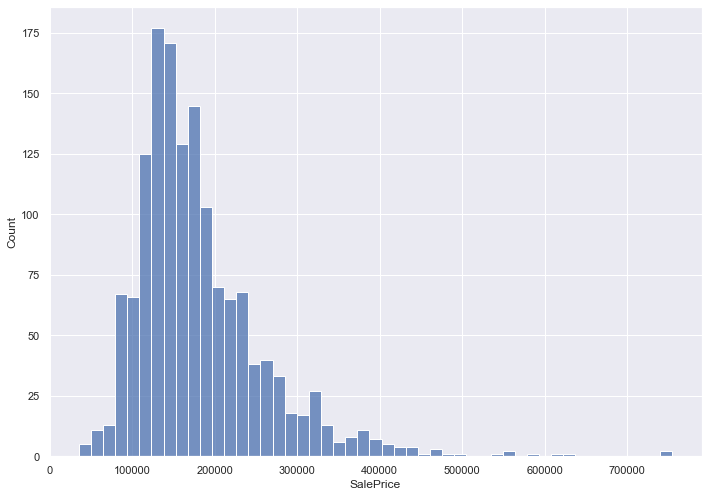

In [5]:
sns.histplot(train_data['SalePrice'])
print(f"Skewness: {train_data['SalePrice'].skew()}")
print(f"Kurtosis: {train_data['SalePrice'].kurtosis()}")

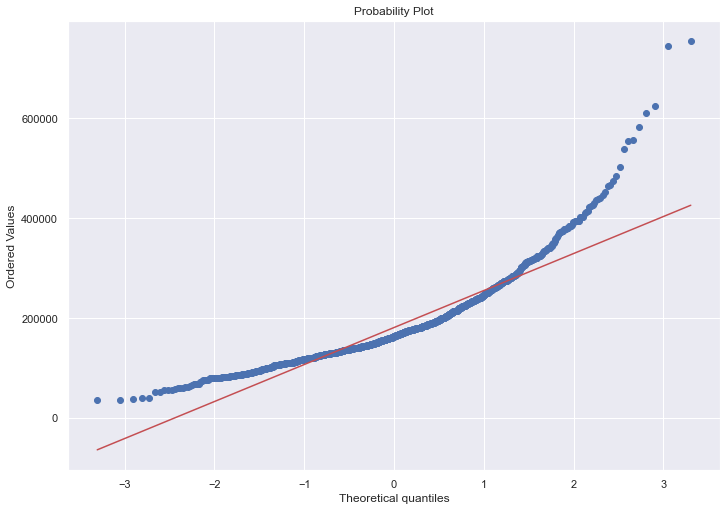

In [6]:
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

Since the charts clearly show right-skewness, target variable could benefit from log transformation with higher degree of normal distribution.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

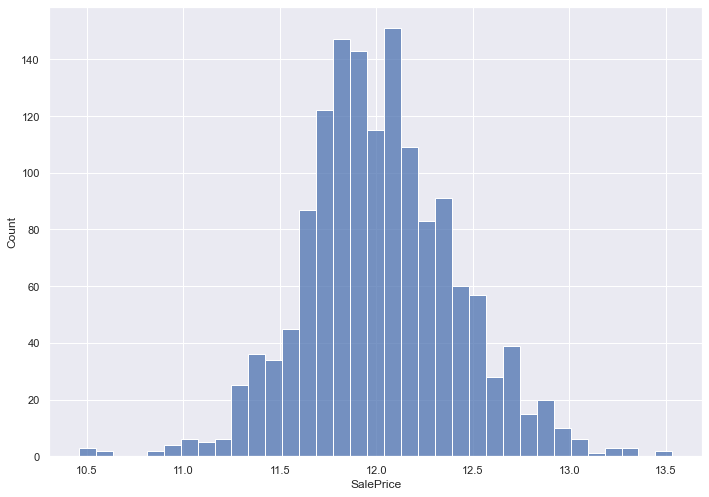

In [7]:
sns.histplot(np.log1p(train_data["SalePrice"]))

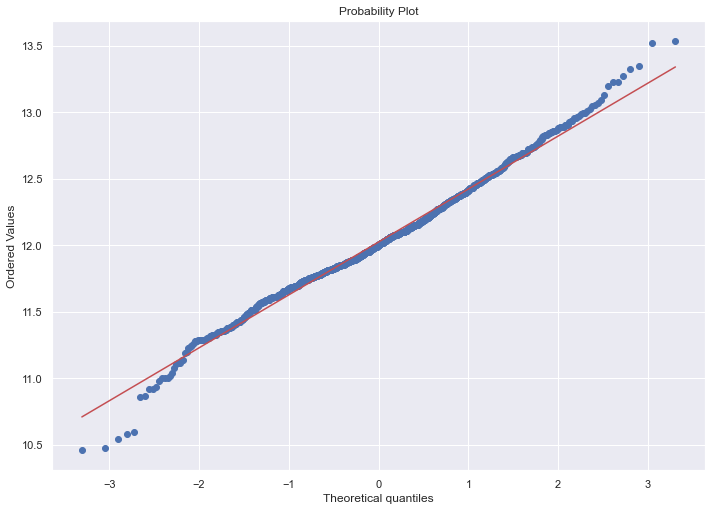

In [8]:
stats.probplot(np.log1p(train_data["SalePrice"]), plot=plt)
plt.show()

It is obvious that target variable's distribution became more normal after the log transformation. This should help increase estimators' accuracy.

In [9]:
sale_price = train_data["SalePrice"]
y_train = np.log1p(train_data["SalePrice"]).values
train_data.drop(columns='SalePrice', inplace=True)

# Ordinal data

The following list of columns has been acquired by skimming through the ```data_description.txt``` documentation of the data.

At first sight it showed clear ordinality by its description and values.

In [10]:
columns_to_ordinal = [
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
    'CentralAir',
    'PavedDrive',
    'LotShape',
    'GarageFinish',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'MasVnrType',
    'Functional',
    'Alley'
]

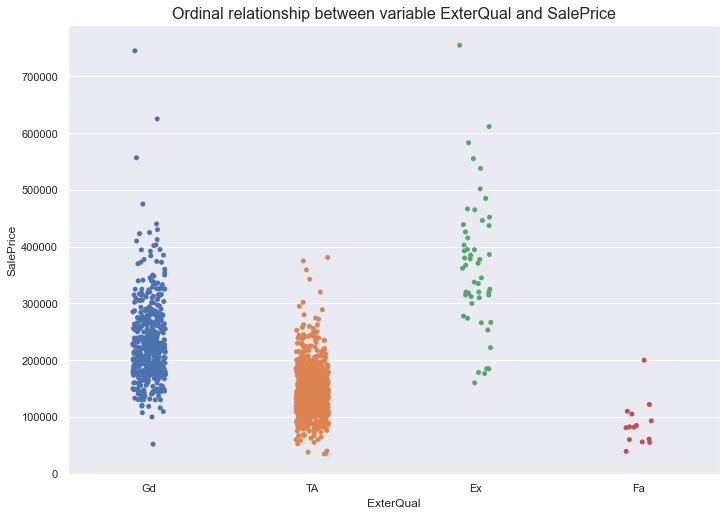

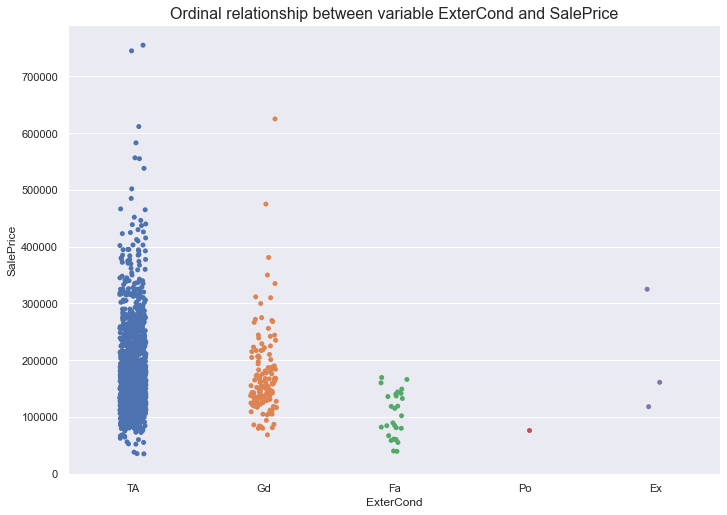

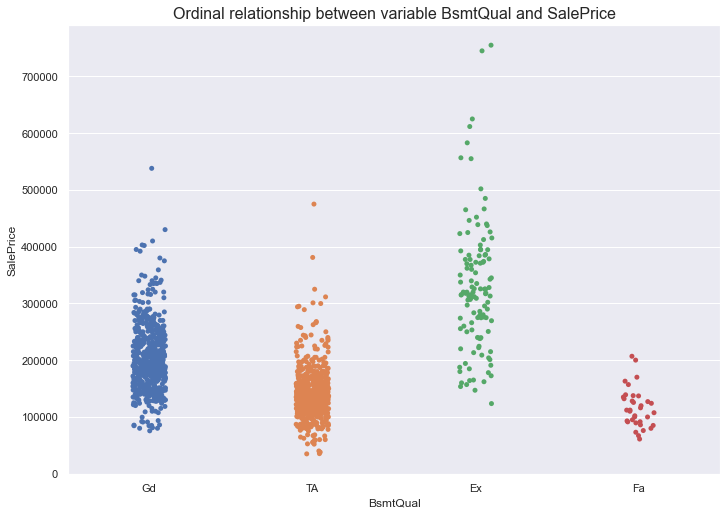

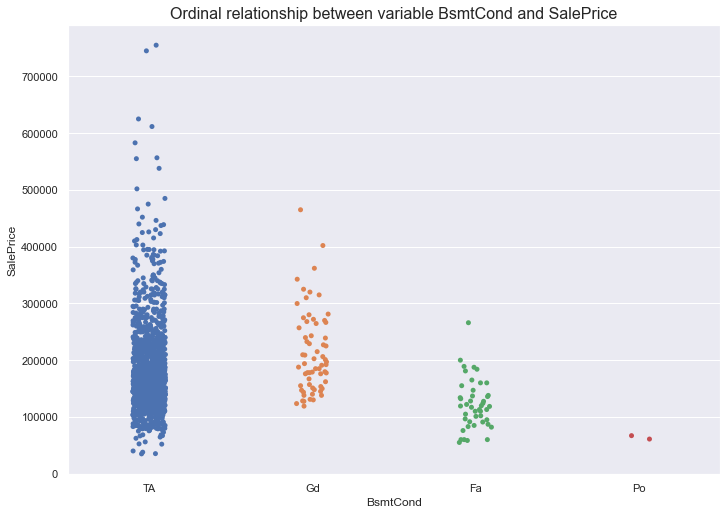

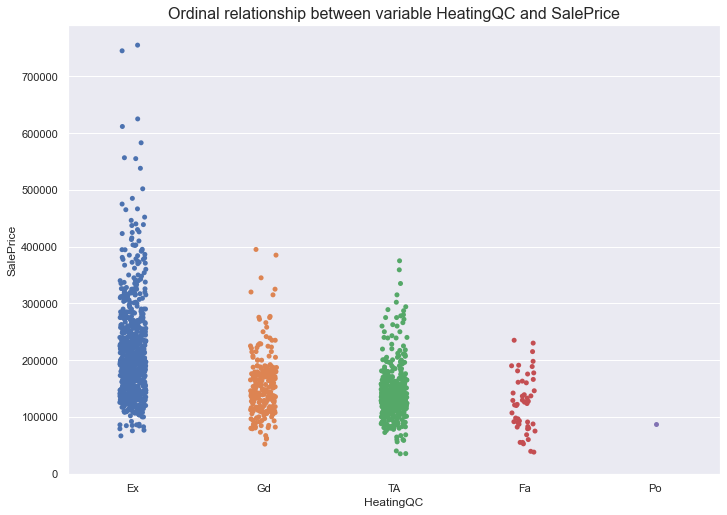

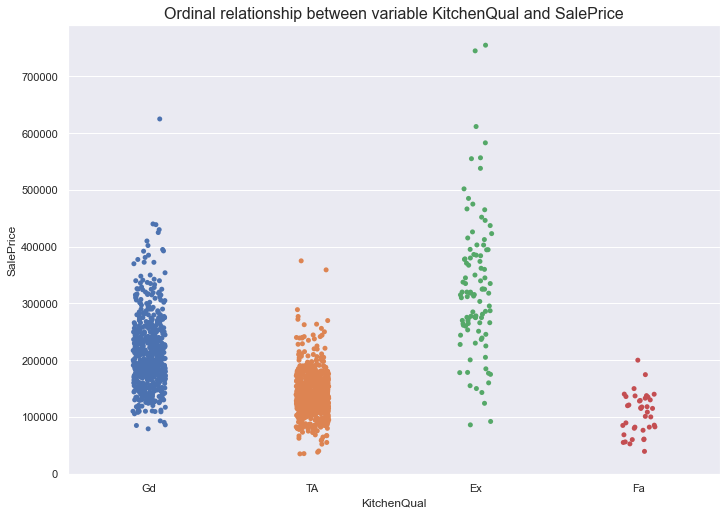

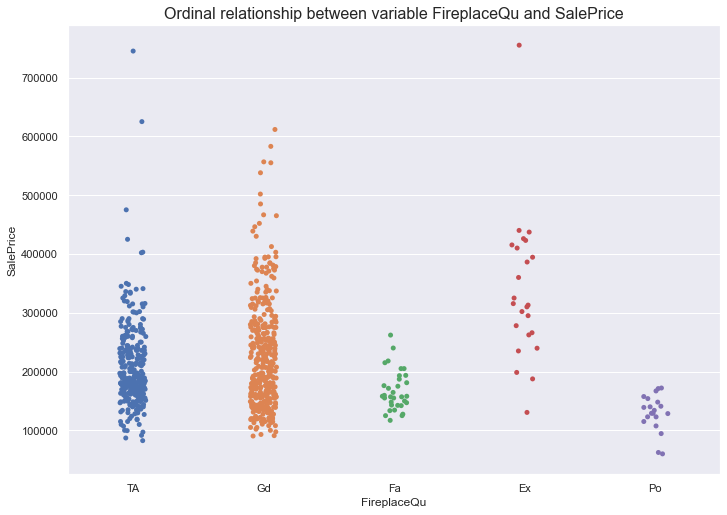

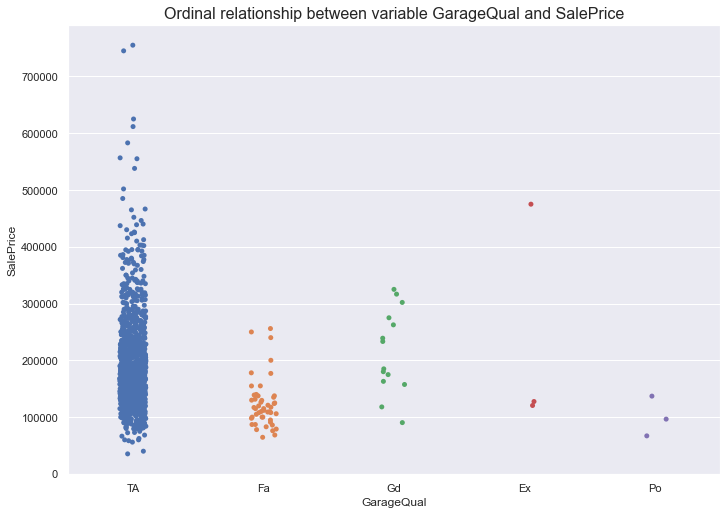

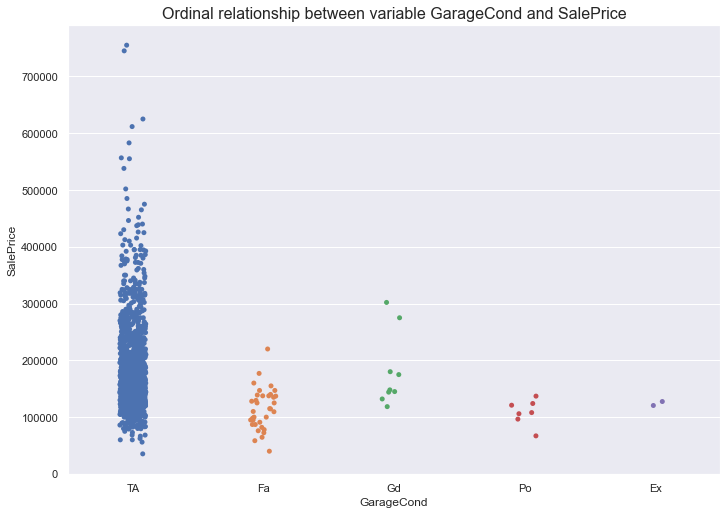

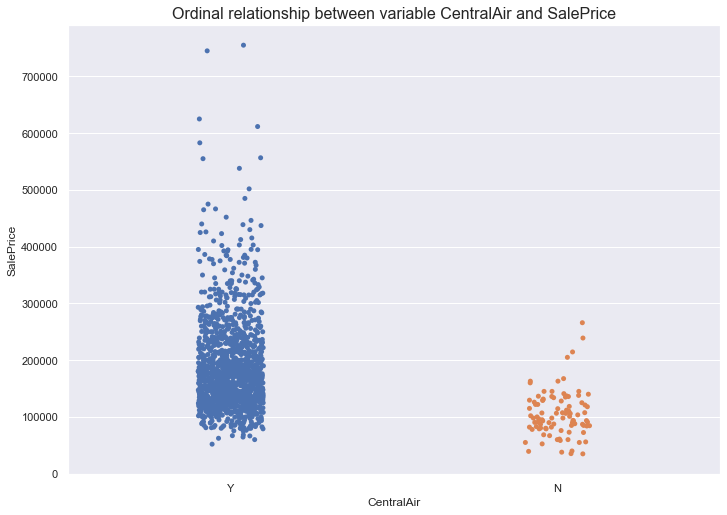

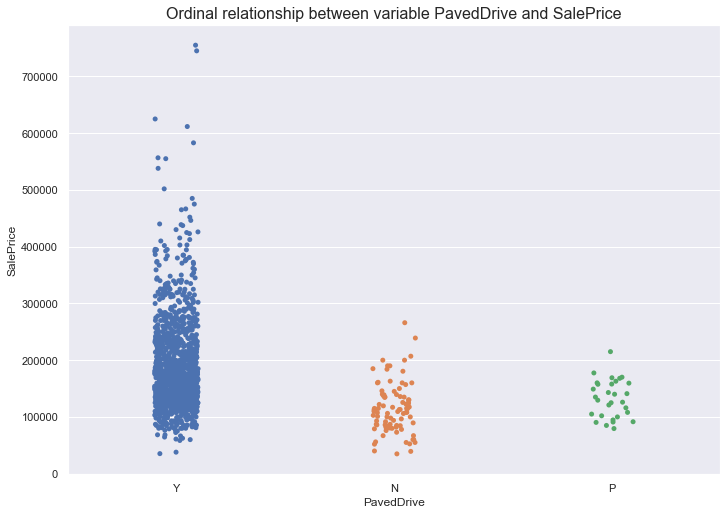

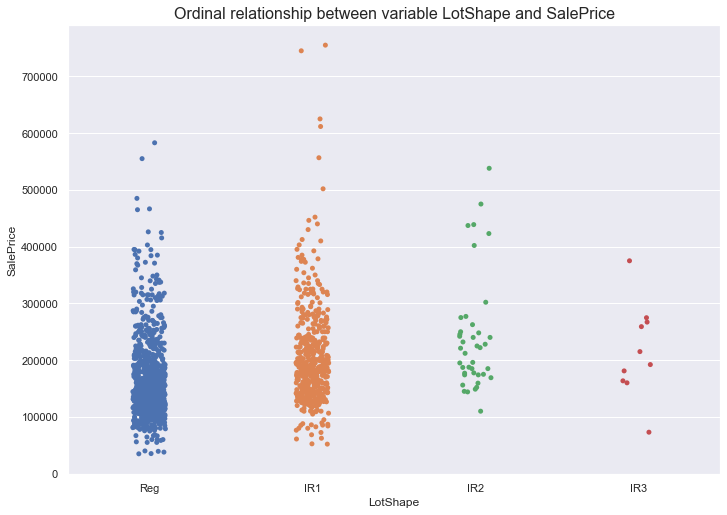

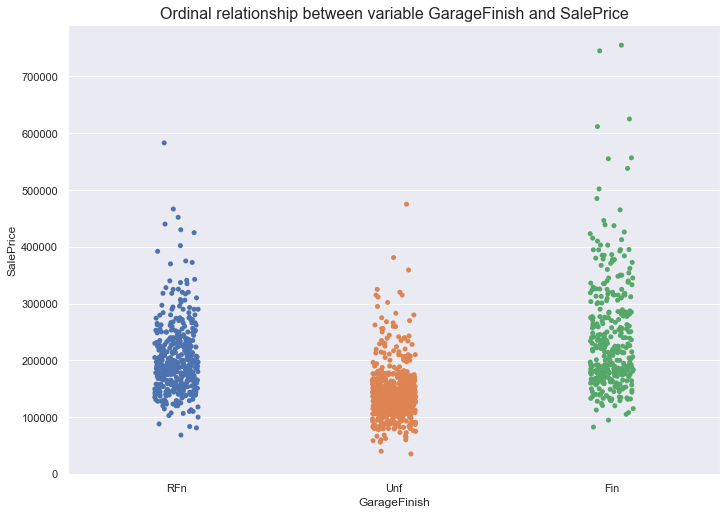

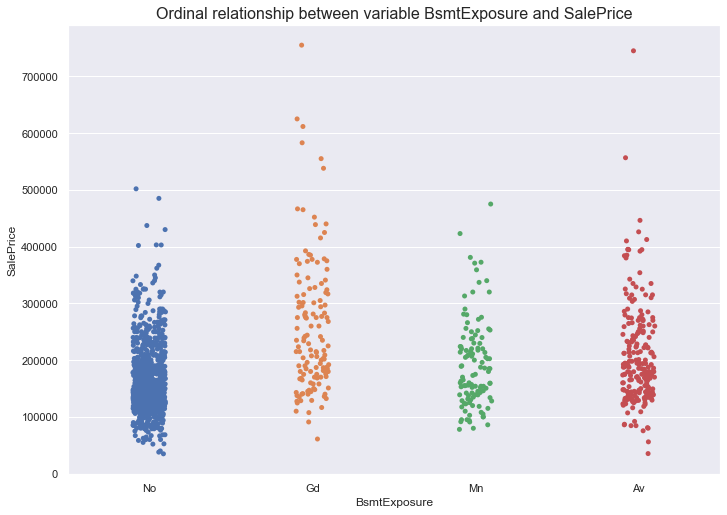

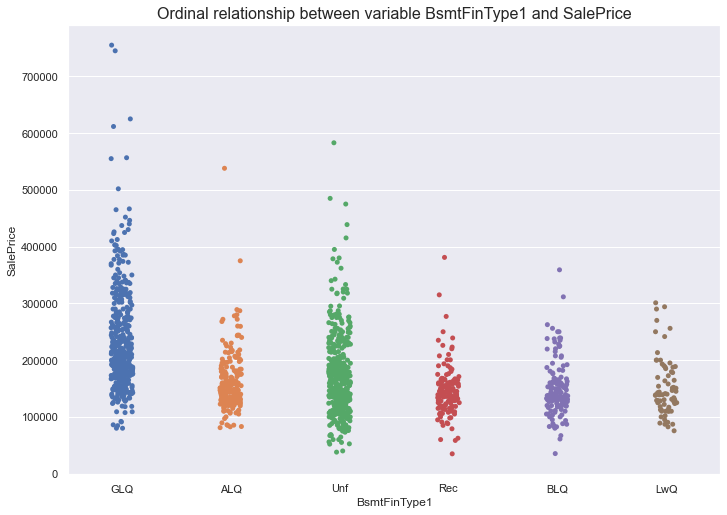

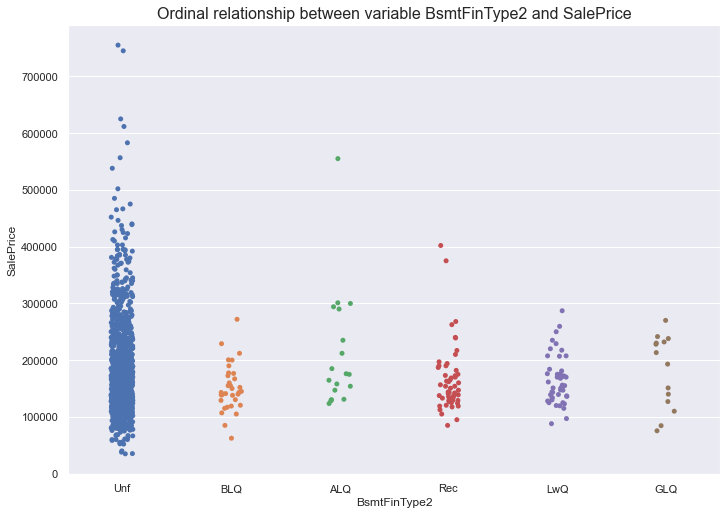

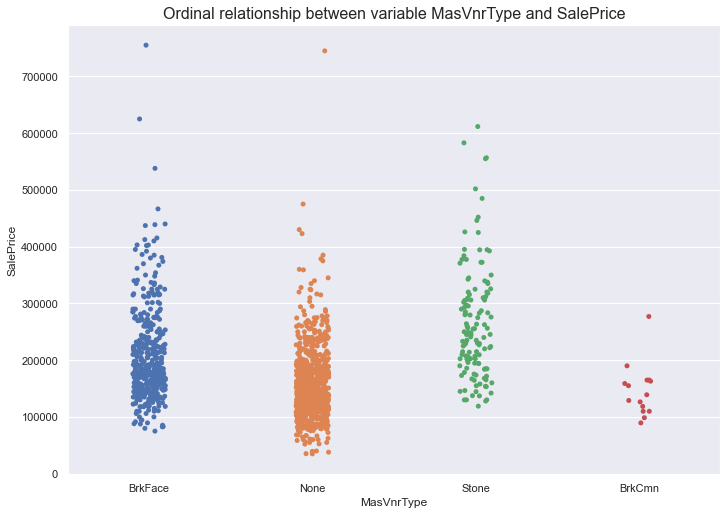

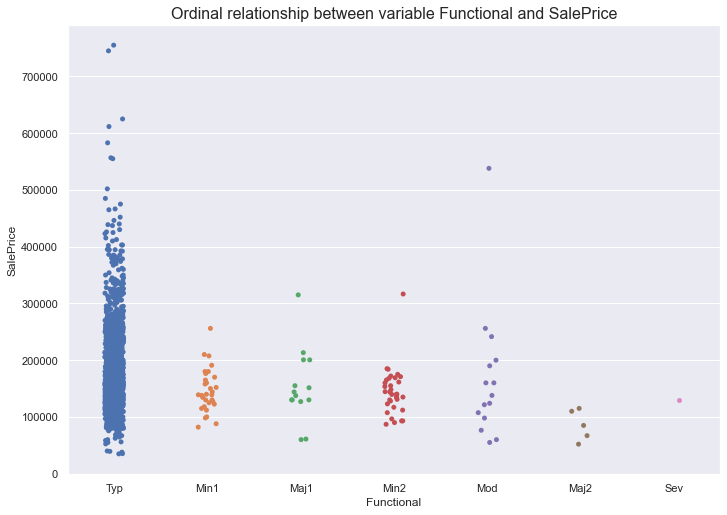

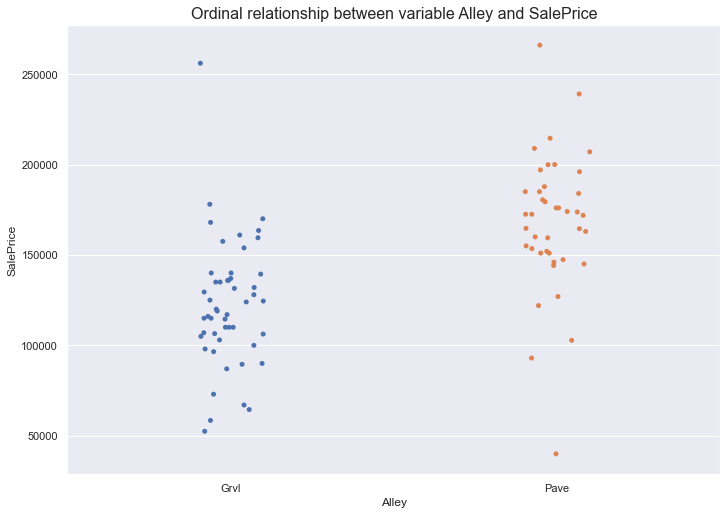

In [11]:
for i, feature in enumerate(columns_to_ordinal, 1):
    plt.figure()
    sns.stripplot(
        data=train_data,
        x=feature,
        y=sale_price
    )
    plt.title(
        f"Ordinal relationship between variable {feature} and SalePrice",
        fontsize=16
    )

Those are hand picked variables from the ```data_description.txt```.

Most of them show clear ordinal relationship with the price and thus are preprocessed as ordinal data later on in the pipeline.

For the variables above who do not show clear relationship - I still treat them as ordinal variables in preprocessing since their semantic value suggests ordinality.

# Missing values

In [12]:
def missing_values_table(df) -> pd.DataFrame:
    """
    Counts total columns and columns with missing values.
    Print out the information in form of a string and dataframe.

    Returns:
        mis_val_table_ren_columns (pd.DataFrame):
            dataframe with count of missing values and percentage with respect to total values of the variable
    """
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )
    mis_val_table_ren_columns = (
        mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    print(
        "Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
        "There are "
        + str(mis_val_table_ren_columns.shape[0])
        + " columns that have missing values."
    )
    return mis_val_table_ren_columns

In [13]:
missing_values_table(train_data)

Your selected dataframe has 80 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
GarageQual,81,5.5


In [14]:
missing_values_table(test_data)

Your selected dataframe has 80 columns.
There are 33 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1456,99.8
MiscFeature,1408,96.5
Alley,1352,92.7
Fence,1169,80.1
FireplaceQu,730,50.0
LotFrontage,227,15.6
GarageCond,78,5.3
GarageYrBlt,78,5.3
GarageQual,78,5.3
GarageFinish,78,5.3


Decision to imput ```None``` or ```0``` is solely based on the documentation of the data in ```data_description.txt```.

Nonetheless, there are 3 variables with numeric data type when by their meaning they should be classified as categorical columns.

In [15]:
columns_to_imput_none = [
    'PoolQC',
    'MiscFeature',
    'Fence',
    'GarageType'
]

columns_to_imput_zero = [
    'GarageYrBlt',
    'GarageArea',
    'GarageCars',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'MasVnrArea'
]

columns_to_object_type = [
    'MSSubClass',
    'YrSold',
    'MoSold'
]

In [16]:
all_numerical_columns = list(train_data.select_dtypes(include="number").columns)
# All of the non-imputed numeric columns
all_numerical_unique = [
    x
    for x in all_numerical_columns
    if x not in (columns_to_imput_zero + columns_to_object_type)
]

In [17]:
all_categorical_columns = list(train_data.select_dtypes(exclude="number").columns)
# All of the non-imputed categorical columns
all_categorical_unique = [
    x
    for x in all_categorical_columns
    if x not in (columns_to_imput_none + columns_to_ordinal)
]

# Custom Transformers + Functions

In [18]:
class NumericalFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    This class' purpose is to create new numerical features by taking various combinations of existing features.
    This is used in developing custom pipeline to increase model's accuracy.

    Returns:
        X.values ([np.array]): nine new numerical features engineered
    """
    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> np.array:
        X = X.copy()

        X["LivLotRatio"] = X["GrLivArea"] / X["LotArea"]
        X["Spaciousness"] = (X["1stFlrSF"] + X["2ndFlrSF"]) / X["TotRmsAbvGrd"]
        X["TotalOutsideSF"] = (
            X["WoodDeckSF"]
            + X["OpenPorchSF"]
            + X["EnclosedPorch"]
            + X["3SsnPorch"]
            + X["ScreenPorch"]
        )
        X["PorchTypes"] = (
            X[
                [
                    "WoodDeckSF",
                    "OpenPorchSF",
                    "EnclosedPorch",
                    "3SsnPorch",
                    "ScreenPorch",
                ]
            ]
            .gt(0.0)
            .sum(axis=1)
        )
        X["MedNhbdArea"] = X.groupby("Neighborhood")["GrLivArea"].transform("median")
        X["TotalSF_1"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
        X["Total_Bathrooms"] = (
            X["FullBath"]
            + (0.5 * X["HalfBath"])
            + X["BsmtFullBath"]
            + (0.5 * X["BsmtHalfBath"])
        )
        X["OtherRooms"] = X["TotRmsAbvGrd"] - X["BedroomAbvGr"] - X["KitchenAbvGr"]
        X["TotalSF_2"] = (
            X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["1stFlrSF"] + X["2ndFlrSF"]
        )

        X = X.iloc[:, -9:]

        return X.values


class BinaryFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    This class' purpose is to create new binary features by taking problematic features and converting them to 0 or 1.
    This is used in developing custom pipeline to increase model's accuracy.

    Returns:
        X.values ([np.array]): five new binary features engineered
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X: pd.DataFrame, y=None) -> np.array:
        X = X.copy()

        X["Has_pool"] = X["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
        X["Has_2nd_floor"] = X["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
        X["Has_garage"] = X["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
        X["Has_bsmt"] = X["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
        X["Has_fireplace"] = X["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)

        X = X.iloc[:, -5:]

        return X.values


def columns_to_object(x: list) -> pd.DataFrame:
    return pd.DataFrame(x).astype(object)


def rmsle_cv(model, X: pd.DataFrame, y: pd.Series) -> float:
    """
    This function's main purpose is to perform cross-validation with root mean squared error score as an ouput.

    Args:
        model: Pipeline or model to be fitted and used for cross-validation
        X (pd.DataFrame): Training variables
        y (pd.Series): Target variable

    Returns:
        rmse (float): Average cross-validation root mean squared error
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=1).get_n_splits(X.values)
    rmse = np.sqrt(
        -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf)
    ).mean()
    return rmse


def predictions_to_csv(predictions: np.array, model_name: str) -> None:
    """
    Function converts predictions of a certain estimator to a csv file.

    Args:
        predictions (np.array): prediction of the target variable preferably on the test data
        model_name (str): name of the estimator
    """
    test_ID = test_data["Id"].values
    sub = pd.DataFrame()
    sub["Id"] = test_ID
    sub["SalePrice"] = predictions
    sub.to_csv(f"{model_name}.csv", index=False)

# Base pipelines

The model's of this notebook will share the same ```base``` pipelines.

However, to increase some model's accuracy they will be modified further down the notebook.

In [19]:
base_ordinal_pipe = Pipeline(
    steps=[
        (
            "ordinal",
            ColumnTransformer(
                transformers=[
                    (
                        "none_imputer",
                        SimpleImputer(strategy="constant", fill_value="None"),
                        columns_to_ordinal,
                    )
                ]
            )
        ),
        (
            "encoder",
            OrdinalEncoder(
                categories="auto", handle_unknown="use_encoded_value", unknown_value=-1
            )
        )
    ]
)

base_categorical_pipe = Pipeline(
    steps=[
        (
            "categorical",
            ColumnTransformer(
                transformers=[
                    (
                        "to_object_type",
                        FunctionTransformer(columns_to_object, validate=False),
                        columns_to_object_type,
                    ),
                    (
                        "none_imputer",
                        SimpleImputer(strategy="constant", fill_value="None"),
                        columns_to_imput_none,
                    ),
                    (
                        "mode_imputer",
                        SimpleImputer(strategy="most_frequent"),
                        all_categorical_unique,
                    )
                ]
            )
        ),
        ("encoder", OneHotEncoder(categories="auto", handle_unknown="ignore"))
    ]
)

base_numerical_pipe = Pipeline(
    steps=[
        (
            "numerical",
            ColumnTransformer(
                transformers=[
                    (
                        "zero_imputer",
                        SimpleImputer(strategy="constant", fill_value=0),
                        columns_to_imput_zero,
                    ),
                    (
                        "median_imputer",
                        SimpleImputer(strategy="median"),
                        all_numerical_unique,
                    )
                ]
            )
        )
    ]
)

# GRB

Gradient Boosting Regressor hugely benefit by merely adding RobustScaler to its numerical pipeline.

RobustScaler's main advantage its robustness to outliers and since we did not focus at all on outliers, it is not surprising it scores best among other scalers.

The way it deals with outliers is fantastically defined in the documentation:

```This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).```

In [20]:
grb_numerical_pipe = Pipeline(
    steps=[("base_numeric_pipe", base_numerical_pipe), ("scaler", RobustScaler())]
)

In [21]:
grb_pipe = Pipeline(
    steps=[
        (
            "preprocess_data_in_parallel",
            FeatureUnion(
                transformer_list=[
                    ("ordinal_pipe", base_ordinal_pipe),
                    ("categorical_pipe", base_categorical_pipe),
                    ("numerical_pipe", grb_numerical_pipe),
                ]
            )
        ),
        (
            "model",
            GradientBoostingRegressor(
                loss="huber",
                alpha=0.7,
                learning_rate=0.09,
                n_estimators=260,
                subsample=0.8,
                max_depth=3,
                max_features="sqrt",
                random_state=1,
            )
        )
    ]
)

X = train_data.copy()
y = y_train

grb = grb_pipe.fit(X, y)

GBR Pipeline Schema:

![GBR schema](https://i.imgur.com/nwNF59U.jpg)


In [22]:
grb_rmsle = round(rmsle_cv(grb, X, y), 4)

print(f"Root Mean Squared Logarithmic Error of GradientBoostingRegressor is {grb_rmsle}")

Root Mean Squared Logarithmic Error of GradientBoostingRegressor is 0.1189


In [23]:
%%time
grb_model = grb.fit(train_data, y_train)

Wall time: 1.23 s


In [24]:
%%time
grb_predictions = np.expm1(grb_model.predict(test_data))

Wall time: 123 ms


In [25]:
# predictions_to_csv(grb_predictions, 'grb_tree')

# XGB

To build a great XGBRegressor's model, I had to use StandardScaler and include some feature engineering.

StandartScaler's main purpose is to transform numerical values to simple z-score values.

However, the main reduction in overfitting (when tested on Kaggle) has been noticed when parameter ```colsample_bytree``` was tuned.

This hyperparameter is ```the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed``` as per documentation states.

This hyperparameter simply means that each random tree selects a random sample from the dataset to train the tree. Then, for each node of this that tree, it uses a random subset of the selected features. This avoids overfitting and decorrelates the trees.

In [26]:
xgb_numerical_pipe = Pipeline(
    steps=[("base_numerical_pipe", base_numerical_pipe), ("scaler", StandardScaler())]
)

xgb_combined_feature_eng = FeatureUnion(
    transformer_list=[
        (
            "numerical_features",
            Pipeline(
                steps=[
                    ("num_feat_eng", NumericalFeatureEngineer()),
                    ("impute_missing", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
        ),
        (
            "categorical_features",
            Pipeline(
                steps=[
                    ("cat_feat_eng", BinaryFeatureEngineer()),
                    (
                        "impute_missing",
                        SimpleImputer(strategy="constant", fill_value=0),
                    ),
                ]
            ),
        ),
    ]
)


In [27]:
xgb_pipe = Pipeline(
    steps=[
        (
            "preprocess_data_in_parallel",
            FeatureUnion(
                transformer_list=[
                    ("ordinal_pipe", base_ordinal_pipe),
                    ("categorical_pipe", base_categorical_pipe),
                    ("numerical_pipe", xgb_numerical_pipe),
                    ("feature_engineering", xgb_combined_feature_eng)
                ]
            )
        ),
        (
            "feature_selection",
            SelectFromModel(
                estimator=LinearRegression(), threshold="0.1*median", prefit=False
            )
        ),
        (
            "model",
            XGBRegressor(
                learning_rate=0.085,
                n_estimators=200,
                max_depth=3,
                reg_lambda=0.75,
                random_state=1,
                min_split_loss=0.001,
                colsample_bytree=0.275,
            )
        )
    ]
)

X = train_data.copy()
y = y_train
xgb = xgb_pipe.fit(X, y)

XGB Pipeline schema:

![XGB Pipeline Schema](https://i.imgur.com/Z28I5US.jpg)

In [28]:
xgb_rmsle = round(rmsle_cv(xgb, X, y), 4)

print(f"Root Mean Squared Logarithmic Error of XGBRegressor is {xgb_rmsle}")

Root Mean Squared Logarithmic Error of XGBRegressor is 0.1191


In [29]:
%%time
xgb_model = xgb.fit(train_data, y_train)

Wall time: 596 ms


In [30]:
%%time
xgb_predictions = np.expm1(xgb_model.predict(test_data))

Wall time: 63.8 ms


In [31]:
# predictions_to_csv(xgb_predictions, "xgb_tree")

# MLP

The most problematic model was MLPRegressor. All the parts of the pipeline strongly benefited from QuantileTransformer as a scaler.

```QuantileTransformer uses quantile information to transform features which follow either uniform or normal distribution. It strongly reduces the impact of outliers since it spreads out the most frequent values - mkaking it robust preprocessing tool.```

This model was the only one who scored above ```0.13``` on kaggle test dataset.

That was a decision to leave the model as simple as it is (only one layer with 100 neurons) and sacrifice a bit of accuracy for speed and simplicity.

In [32]:
mlp_ordinal_pipe = Pipeline(
    steps=[
        ('base_ordinal', base_ordinal_pipe),
        ("scale_ordinal_nnet", QuantileTransformer())
    ]
)

mlp_categorical_pipe = Pipeline(
    steps=[
        ("base_categorical_pipe", base_categorical_pipe),
        ("scaler", QuantileTransformer())
    ]
)

mlp_numerical_pipe = Pipeline(
    steps=[
        ('base_numerical_pipe', base_numerical_pipe),
        ("scaler", QuantileTransformer())
    ]
)

mlp_combined_feature_eng = FeatureUnion(
    transformer_list=[
        (
            "numerical_features",
            Pipeline(
                steps=[
                    ("num_feat_eng", NumericalFeatureEngineer()),
                    ("impute_missing", SimpleImputer(strategy="median")),
                    ("scaler", QuantileTransformer())
                ]
            )
        ),
        (
            "categorical_features",
            Pipeline(
                steps=[
                    ("cat_feat_eng", BinaryFeatureEngineer()),
                    (
                        "impute_missing",
                        SimpleImputer(strategy="constant", fill_value=0),
                    ),
                    ("scaler", QuantileTransformer())
                ]
            )
        )
    ]
)


In [33]:
nnet_pipe = Pipeline(
    steps=[
        (
            "preprocess_data_in_parallel",
            FeatureUnion(
                transformer_list=[
                    ("ordinal_pipe", mlp_ordinal_pipe),
                    ("categorical_pipe", mlp_categorical_pipe),
                    ("numerical_pipe", mlp_numerical_pipe),
                    ("feature_engineering", mlp_combined_feature_eng)
                ]
            )
        ),
        (
            "model",
            MLPRegressor(
                activation="logistic",
                solver="sgd",
                learning_rate="adaptive",
                learning_rate_init=0.025,
                hidden_layer_sizes=(100,),
                alpha=0.51,
                max_iter=10000,
                random_state=1,
            )
        )
    ]
)

X = train_data.copy()
y = y_train

nnet = nnet_pipe.fit(X, y)

MLP Pipeline Schema:

![MLP pipe schema](https://i.imgur.com/FVLJQQz.jpg)

In [34]:
nnet_rmsle = round(rmsle_cv(nnet, X, y), 4)

print(f"Root Mean Squared Logarithmic Error of MLPRegressor is {nnet_rmsle}")

Root Mean Squared Logarithmic Error of MLPRegressor is 0.131


In [35]:
%%time
nnet_model = nnet.fit(train_data, y_train)

Wall time: 13.7 s


In [36]:
%%time
nnet_predictions = np.expm1(nnet_model.predict(test_data))

Wall time: 80.3 ms


In [37]:
# predictions_to_csv(nnet_predictions, "nnet")

# Model comparison


In [38]:
pd.DataFrame(
    {
        "Model": ["GRB", "XGB", "MLP"],
        "RMSLE": [grb_rmsle, xgb_rmsle, nnet_rmsle],
        "Kaggle": [0.1295, 0.1243, 0.1347]
    }
)

,Model,RMSLE,Kaggle
0,GRB,0.1189,0.1295
1,XGB,0.1191,0.1243
2,MLP,0.1310,0.1347


It is clear that the best model to use regarding this problem is XGBRegressor.